In [1]:
import glob
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

In [2]:
PROJECT_DIR_s = "/fs/cbsuhy02/storage/yc2553/yc2553/projects/TRE_directionality/softwares/procapnet/"
PROJECT_DIR_d = "/fs/cbsuhy02/storage/yc2553/yc2553/projects/TRE_directionality/PROcap/"
PROJECT_DIR_r = "/fs/cbsuhy02/storage/yc2553/yc2553/projects/TRE_directionality/resources/"
PROJECT_DIR_o = "/fs/cbsuhy02/storage/yc2553/yc2553/projects/TRE_directionality/output/procapnet/"

# Input data

In [11]:
# Motifs that are critical for directionality are definitely critical for transcriptoin (total counts); motifs critical for transcriptoin (total counts) can affect directionality either through orientation-specific effects or position-specific effects (so there is no need to develop a different model to directly predict directionality).
# We'll employ PROcapNet model to identify motifs with or without orientation bias (default parameters except that we use 1000 as in-window size and 500 as out-window size).
# We include all bidirectional and unidirectional elements (no filtering).

In [3]:
script = f"{PROJECT_DIR_s}slurm/input.sh"
s = "HCT116"
acc = f"{PROJECT_DIR_r}ENCODE/ENCFF240LRP.bed.gz"
prefix = "brm_CTCF_U1_and_CTCF_U2_erm"
sex = "M"
commands = " ".join(["sbatch", script,
					 PROJECT_DIR_d,
					 prefix,
					 f"{PROJECT_DIR_o}processed/{s}",
					 acc, 
					 sex
					])
print(commands)

sbatch /fs/cbsuhy02/storage/yc2553/yc2553/projects/TRE_directionality/softwares/procapnet/slurm/input.sh /fs/cbsuhy02/storage/yc2553/yc2553/projects/TRE_directionality/PROcap/ brm_CTCF_U1_and_CTCF_U2_erm /fs/cbsuhy02/storage/yc2553/yc2553/projects/TRE_directionality/output/procapnet/processed/HCT116 /fs/cbsuhy02/storage/yc2553/yc2553/projects/TRE_directionality/resources/ENCODE/ENCFF240LRP.bed.gz M


In [4]:
# No. peaks

! zcat $PROJECT_DIR_o/processed/$s/peaks.bed.gz | wc -l

49585


# Train models

In [ ]:
# Set the parameters in "hyperparameter.py"
# self.in_window = 1000
# self.out_window = 500
# source_fracs = [1,0]

In [5]:
# add gpu at the end

model_type = "strand_merged_umap"
script = f"{PROJECT_DIR_s}slurm/train.sh"
for fold in range(1,8):
	commands = " ".join(["sbatch", script, 
						s,
						model_type,
						PROJECT_DIR_o,
						str(fold)
						])
	print(commands)

sbatch /fs/cbsuhy02/storage/yc2553/yc2553/projects/TRE_directionality/softwares/procapnet/slurm/train.sh HCT116 strand_merged_umap /fs/cbsuhy02/storage/yc2553/yc2553/projects/TRE_directionality/output/procapnet/ 1
sbatch /fs/cbsuhy02/storage/yc2553/yc2553/projects/TRE_directionality/softwares/procapnet/slurm/train.sh HCT116 strand_merged_umap /fs/cbsuhy02/storage/yc2553/yc2553/projects/TRE_directionality/output/procapnet/ 2
sbatch /fs/cbsuhy02/storage/yc2553/yc2553/projects/TRE_directionality/softwares/procapnet/slurm/train.sh HCT116 strand_merged_umap /fs/cbsuhy02/storage/yc2553/yc2553/projects/TRE_directionality/output/procapnet/ 3
sbatch /fs/cbsuhy02/storage/yc2553/yc2553/projects/TRE_directionality/softwares/procapnet/slurm/train.sh HCT116 strand_merged_umap /fs/cbsuhy02/storage/yc2553/yc2553/projects/TRE_directionality/output/procapnet/ 4
sbatch /fs/cbsuhy02/storage/yc2553/yc2553/projects/TRE_directionality/softwares/procapnet/slurm/train.sh HCT116 strand_merged_umap /fs/cbsuhy02/

# Evaluate models

In [6]:
files = glob.glob(f"{PROJECT_DIR_o}models/{s}/{model_type}/*.model")
timestamps = sorted([f.split("/")[-1].split(".model")[0] for f in files])

In [7]:
# Add GPU name at the end

script = f"{PROJECT_DIR_s}slurm/eval.sh"
for k in timestamps:
	fold, timestamp = k.split(".") 
	commands = " ".join(["sbatch", script, 
						s,
						model_type,
						PROJECT_DIR_o,
						fold,
						timestamp
						])
	print(commands)

sbatch /fs/cbsuhy02/storage/yc2553/yc2553/projects/TRE_directionality/softwares/procapnet/slurm/eval.sh HCT116 strand_merged_umap /fs/cbsuhy02/storage/yc2553/yc2553/projects/TRE_directionality/output/procapnet/ 1 2024-10-21_23-38-55
sbatch /fs/cbsuhy02/storage/yc2553/yc2553/projects/TRE_directionality/softwares/procapnet/slurm/eval.sh HCT116 strand_merged_umap /fs/cbsuhy02/storage/yc2553/yc2553/projects/TRE_directionality/output/procapnet/ 2 2024-10-22_00-25-53
sbatch /fs/cbsuhy02/storage/yc2553/yc2553/projects/TRE_directionality/softwares/procapnet/slurm/eval.sh HCT116 strand_merged_umap /fs/cbsuhy02/storage/yc2553/yc2553/projects/TRE_directionality/output/procapnet/ 3 2024-10-22_00-32-20
sbatch /fs/cbsuhy02/storage/yc2553/yc2553/projects/TRE_directionality/softwares/procapnet/slurm/eval.sh HCT116 strand_merged_umap /fs/cbsuhy02/storage/yc2553/yc2553/projects/TRE_directionality/output/procapnet/ 4 2024-10-22_01-01-35
sbatch /fs/cbsuhy02/storage/yc2553/yc2553/projects/TRE_directionalit

In [8]:
# Check correlation

results = []
model_type = "strand_merged_umap"
for k in timestamps:
	inputfile = f"{PROJECT_DIR_o}model_out/{s}/{model_type}/{k.split('.')[1]}/test_run_log.txt"
	with open(inputfile, "r") as f:
		lines = f.readlines()
		profile = float(lines[-3].strip().split(": ")[1])
		counts = float(lines[-2].strip().split(": ")[1])
		results.append([s, profile, "Profile", k.split(".")[0]])
		results.append([s, counts, "Counts", k.split(".")[0]])
df = pd.DataFrame(results, columns=["Model", "Corr", "Type", "Fold"])

In [9]:
for t in ["Profile", "Counts"]:
	print(t, 
		  round(np.mean(df[df["Type"]==t]["Corr"]),3), 
		  round(np.std(df[df["Type"]==t]["Corr"]),3)
		 )

Profile 0.6 0.004
Counts 0.768 0.014


([0, 1], [Text(0, 0, 'Profile'), Text(1, 0, 'Counts')])

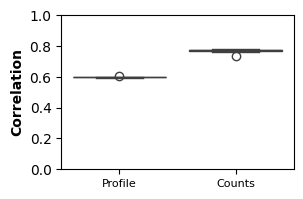

In [10]:
fig, ax = plt.subplots(figsize=(3,2))
g = sns.boxplot(data=df, x="Type", y="Corr", ax=ax)
g.set_ylabel("Correlation", fontsize=10, fontweight="bold")
g.set_xlabel("")
g.set_ylim([0,1])
plt.xticks(fontsize=8) 